# Cypher Queries for Determining Metformin to Fanconi Anemia Paths
*Tong Shu Li, Núria Queralt Rosinach, Matthew Brush, Maureen Hoatlin, Andrew Su*

**NCATS hackathon, January 2018**

## Overview
Fanconi anemia (FA) - Metformin drug repurposing use case using **Monarch knowledge graph** (*scigraph*)

## Monarch servers 

    * Server: bolt://scigraph.ncats.io:443
    * Local SciGraph: bolt://137.131.88.41:7687

### Imports

In [1]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd

### Functions

In [2]:
def parseNode( node ):
    '''
    This function parses the information gathered in the node data structure object resulting after querying neo4j.
        in: node record neo4j object
        out: node as dict
    '''
    n = dict()
    n["id"] = int(node.id)
    n["labels"] = list(node.labels)
    n["iri"] = str(node.properties['iri'])
    n["name"] = str(node.properties['label'])

    return n

def parsePath( path ):
    out = {}
    out['Nodes'] = []
    for node in path['path'].nodes:
        n = {}
        n['idx'] = node.id
        n['label'] = list(node.labels)[0]
        n['id'] = node.properties['id']
        n['preflabel'] = node.properties['preflabel']
        n['description'] = node.properties['description']
        out['Nodes'].append(n)
    out['Edges'] = []
    for edge in path['path'].relationships:
        e = {}
        e['idx'] = edge.id
        e['start_node'] = edge.start
        e['end_node'] = edge.end
        e['type'] = edge.type
        e['preflabel'] = edge.properties['property_label']
        e['references'] = edge.properties['reference_uri']
        out['Edges'].append(e)
        
    return out

### Initialize neo4j

In [3]:
driver = GraphDatabase.driver("bolt://scigraph.ncats.io:443")
#driver = GraphDatabase.driver("bolt://137.131.88.41:7687", auth=("", ""))

### Example query

In [12]:
# run query
with driver.session() as session:
    result = session.run("match (n:Node) where n.label =~ '[mM]etformin' return n")
    
# parse the query results
out_l = list() 
for record in result:
    n = parseNode(record['n'])
    out_l.append(n)
    
# print results    
for i, node in enumerate(out_l):
    print('Node {}:\n\tname: {},\n\tlabel(s): {},\n\tiri: {}\n'.format(i,node.get('name'),node.get('labels'),node.get('iri')))

Node 0:
	name: Metformin,
	label(s): ['Node', 'cliqueLeader', 'Class'],
	iri: http://purl.obolibrary.org/obo/MESH_D008687

Node 1:
	name: metformin,
	label(s): ['Node', 'cliqueLeader', 'Class', 'molecular entity'],
	iri: http://purl.obolibrary.org/obo/CHEBI_6801

Node 2:
	name: metformin,
	label(s): ['Node', 'Class', 'molecular entity'],
	iri: http://www.wikidata.org/entity/Q19484

Node 3:
	name: metformin,
	label(s): ['Node', 'cliqueLeader', 'Class', 'molecular entity'],
	iri: http://fdasis.nlm.nih.gov/srs/unii/9100L32L2N

Node 4:
	name: metformin,
	label(s): ['Node', 'cliqueLeader', 'Class'],
	iri: http://purl.obolibrary.org/obo/XCO_0000408



## Monarch Queries

### Approach
- _Source_: Metformim -- _Target_: FA
- Open query
- Refine query iteratively with the domain expert (Maureen):
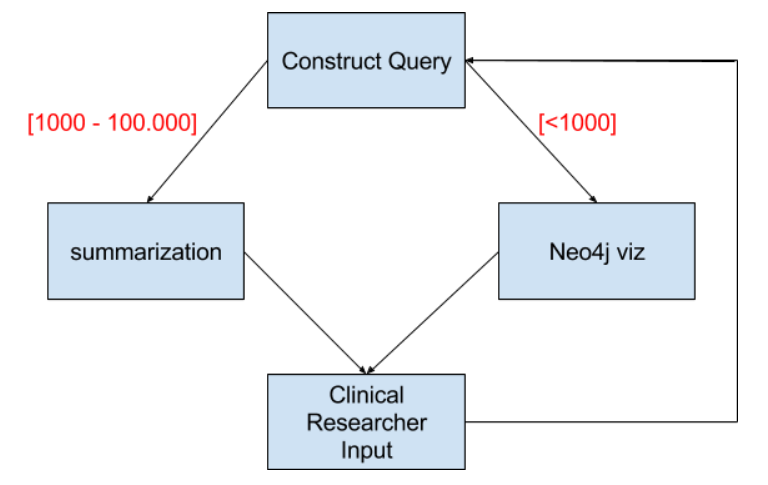

### Round 1: Confirm source/target nodes in scigraph
- Look for iri (index) to speed up queries
- Use 'Node' label to retrieve nodes more efficiently

In [33]:
%%time
# Query for Metformin
with driver.session() as session:
    result = session.run("match (n:Node) where n.label =~ '[mM]etformin' return n")
    
# parse the query results
out_l = list() 
for record in result:
    n = parseNode(record['n'])
    out_l.append(n)

# save to dataframe object 
met_nodes_df = pd.DataFrame(out_l)
print(met_nodes_df)

        id                                            iri  \
0   676045    http://purl.obolibrary.org/obo/MESH_D008687   
1  1604956      http://purl.obolibrary.org/obo/CHEBI_6801   
2  3334454          http://www.wikidata.org/entity/Q19484   
3  3348006  http://fdasis.nlm.nih.gov/srs/unii/9100L32L2N   
4  3866749     http://purl.obolibrary.org/obo/XCO_0000408   

                                          labels       name  
0                    [Class, Node, cliqueLeader]  Metformin  
1  [Class, Node, cliqueLeader, molecular entity]  metformin  
2                [Class, Node, molecular entity]  metformin  
3  [Class, Node, cliqueLeader, molecular entity]  metformin  
4                    [Class, Node, cliqueLeader]  metformin  
CPU times: user 59 ms, sys: 11.9 ms, total: 70.8 ms
Wall time: 7min 8s


- Results: 
    * Metformin is identified by 5 iris
    * Drugs are not yet: 1) defined by ‘drug’ label, 2) designed to merge all the iris into a unique leader superclique
    * Neo4j graph picture:
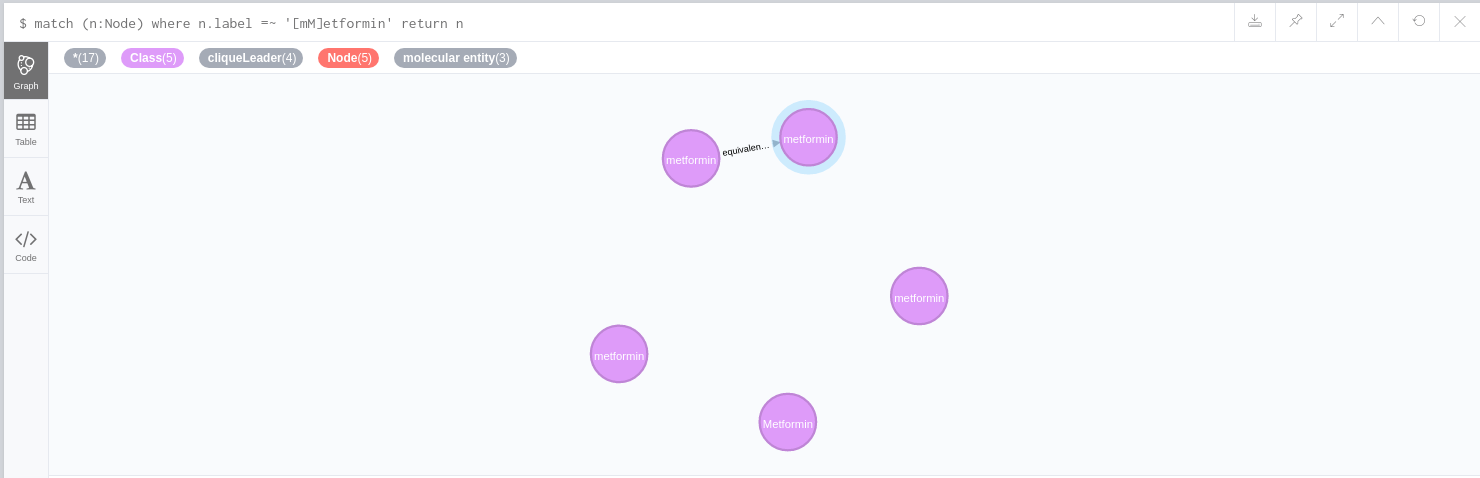

In [34]:
%%time
# Query for FA
with driver.session() as session:
    result = session.run("match (n:Node) where n.label contains 'anconi' return n")
    
# parse the query results
out_l = list() 
for record in result:
    n = parseNode(record['n'])
    out_l.append(n)

# save to dataframe object 
fa_nodes_df = pd.DataFrame(out_l)
print(fa_nodes_df)

          id                                                iri  \
0      22841              http://www.orpha.net/ORDO/Orphanet_84   
1      23777            http://www.orpha.net/ORDO/Orphanet_3337   
2      24904  https://monarchinitiative.org/.well-known/geni...   
3      25383  https://monarchinitiative.org/.well-known/geni...   
4      25486  https://monarchinitiative.org/.well-known/geni...   
5      25972  https://monarchinitiative.org/.well-known/geni...   
6      26903  https://monarchinitiative.org/.well-known/geni...   
7      27488  https://monarchinitiative.org/.well-known/geni...   
8      27879  https://monarchinitiative.org/.well-known/geni...   
9      28310  https://monarchinitiative.org/.well-known/geni...   
10     28495  https://monarchinitiative.org/.well-known/geni...   
11     28501  https://monarchinitiative.org/.well-known/geni...   
12     29015  https://monarchinitiative.org/.well-known/geni...   
13     29201  https://monarchinitiative.org/.well-known/geni..

- Results: 
    *  the disorder has a set of subtypes (subClassOf), also there is a subclass artifact between some nodes derived from merging cases
    
    *  Neo4j graph picture:
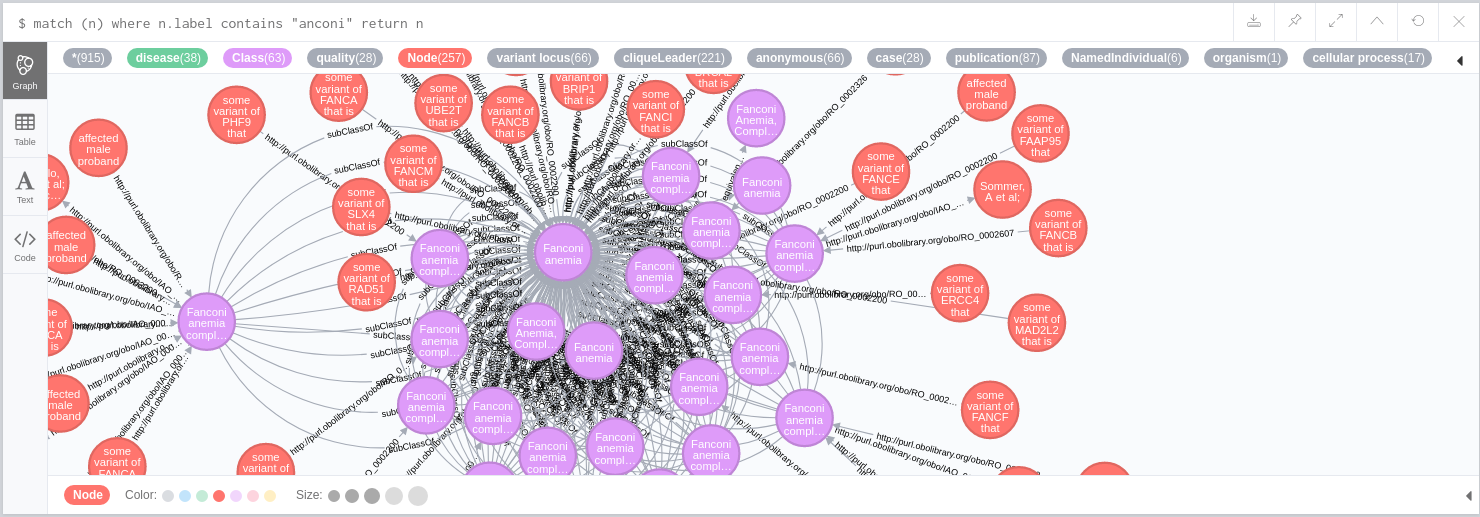

- **Conclusions:**

Detected two possible approaches:

1. To use one instance for each concept

    - Pros
        - Simplicity and to speed up querying
    - Cons
        - Lose of paths that either started only from a specific iri for Metformin or only ended up to FA subtypes
        
        
2. To use a group of instances for each concept

    - Pros
        - We take into account more paths
    - Cons
        - We introduce redundancy through FAsubtypes-subclassof-FA (we can avoid this and some subclass artifacts, filtering paths with this edge type)

### Round 2: Build open queries of different lengths to determine number of paths and time of execution/faisability

* **Query 1:** Look for all paths up to length 4 with the pattern:
    * Metformin--()--()--()--Fanconi anemia
    * Identifying source/target as group of instances
    * Without filters

In [4]:
%%time
# Query 1: Met---FA up to length 4
with driver.session() as session:
    result = session.run(
        """
        match path=(met:Node)-[r1]-(n2)-[r2]-(n3)-[r3]-(n4)-[r4]-(fa:Node)
        where met.iri in ["http://purl.obolibrary.org/obo/MESH_D008687",
                          "http://fdasis.nlm.nih.gov/srs/unii/9100L32L2N",
                          "http://purl.obolibrary.org/obo/CHEBI_6801",
                          "http://www.wikidata.org/entity/Q19484"] and 
              fa.iri in ["http://purl.obolibrary.org/obo/MONDO_0019391",
                         "http://purl.obolibrary.org/obo/MONDO_0009213",
                         "http://purl.obolibrary.org/obo/MONDO_0011584",
                         "http://purl.obolibrary.org/obo/MONDO_0009214",
                         "http://purl.obolibrary.org/obo/MONDO_0010953",
                         "http://purl.obolibrary.org/obo/MONDO_0013565",
                         "http://purl.obolibrary.org/obo/MONDO_0013566",
                         "http://purl.obolibrary.org/obo/MONDO_0012565",
                         "http://purl.obolibrary.org/obo/MONDO_0013248",
                         "http://purl.obolibrary.org/obo/MONDO_0013499",
                         "http://purl.obolibrary.org/obo/MONDO_0014108",
                         "http://purl.obolibrary.org/obo/MONDO_0014638",
                         "http://purl.obolibrary.org/obo/MONDO_0014987",
                         "http://purl.obolibrary.org/obo/MONDO_0009215",
                         "http://purl.obolibrary.org/obo/MONDO_0010351",
                         "http://purl.obolibrary.org/obo/MONDO_0011325",
                         "http://purl.obolibrary.org/obo/MONDO_0012186",
                         "http://purl.obolibrary.org/obo/MONDO_0012187",
                         "http://purl.obolibrary.org/obo/MONDO_0014986",
                         "http://purl.obolibrary.org/obo/MONDO_0014985"] and 
              ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

104732
CPU times: user 3.94 ms, sys: 285 µs, total: 4.23 ms
Wall time: 12.5 s


- **Query 2:** Look for all paths up to length 3 with the pattern:
    * Metformin--()--()--Fanconi anemia
    * Identifying source/target as group of instances
    * Without filters

In [5]:
%%time
# Query 2: Met---FA up to length 3
with driver.session() as session:
    result = session.run(
        """
        match path=(met:Node)-[r1]-(n2)-[r2]-(n3)-[r3]-(fa:Node)
        where met.iri in ["http://purl.obolibrary.org/obo/MESH_D008687",
                          "http://fdasis.nlm.nih.gov/srs/unii/9100L32L2N",
                          "http://purl.obolibrary.org/obo/CHEBI_6801",
                          "http://www.wikidata.org/entity/Q19484"] and 
              fa.iri in ["http://purl.obolibrary.org/obo/MONDO_0019391",
                         "http://purl.obolibrary.org/obo/MONDO_0009213",
                         "http://purl.obolibrary.org/obo/MONDO_0011584",
                         "http://purl.obolibrary.org/obo/MONDO_0009214",
                         "http://purl.obolibrary.org/obo/MONDO_0010953",
                         "http://purl.obolibrary.org/obo/MONDO_0013565",
                         "http://purl.obolibrary.org/obo/MONDO_0013566",
                         "http://purl.obolibrary.org/obo/MONDO_0012565",
                         "http://purl.obolibrary.org/obo/MONDO_0013248",
                         "http://purl.obolibrary.org/obo/MONDO_0013499",
                         "http://purl.obolibrary.org/obo/MONDO_0014108",
                         "http://purl.obolibrary.org/obo/MONDO_0014638",
                         "http://purl.obolibrary.org/obo/MONDO_0014987",
                         "http://purl.obolibrary.org/obo/MONDO_0009215",
                         "http://purl.obolibrary.org/obo/MONDO_0010351",
                         "http://purl.obolibrary.org/obo/MONDO_0011325",
                         "http://purl.obolibrary.org/obo/MONDO_0012186",
                         "http://purl.obolibrary.org/obo/MONDO_0012187",
                         "http://purl.obolibrary.org/obo/MONDO_0014986",
                         "http://purl.obolibrary.org/obo/MONDO_0014985"] and 
              ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

784
CPU times: user 1.71 ms, sys: 1.9 ms, total: 3.61 ms
Wall time: 892 ms


* **Query 3:** Look for all paths up to length 4 with the pattern:
    * Metformin--()--()--()--Fanconi anemia
    * Identifying source/target as one instance
    * Without filters

In [6]:
%%time
# Query 3: Met---FA up to length 4
with driver.session() as session:
    result = session.run(
        """
        match path=(met)-[]-()-[]-()-[]-()-[]-(fa) 
        match (met:Node {iri:"http://purl.obolibrary.org/obo/MESH_D008687"}), 
              (fa:Node {iri:"http://purl.obolibrary.org/obo/MONDO_0019391"}) 
        where ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

17844
CPU times: user 3.77 ms, sys: 1.07 ms, total: 4.84 ms
Wall time: 760 ms


* **Query 4:** Look for all paths up to length 3 with the pattern:
    * Metformin--()--()--Fanconi anemia
    * Identifying source/target as one instance
    * Without filters

In [7]:
%%time
# Query 4: Met---FA up to length 3
with driver.session() as session:
    result = session.run(
        """
        match path=(met)-[]-()-[]-()-[]-(fa) 
        match (met:Node {iri:"http://purl.obolibrary.org/obo/MESH_D008687"}), 
              (fa:Node {iri:"http://purl.obolibrary.org/obo/MONDO_0019391"}) 
        where ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

250
CPU times: user 2.9 ms, sys: 140 µs, total: 3.04 ms
Wall time: 289 ms


* **Query 5:** Look for all paths up to length 4 with the pattern:
    * Metformin--()--()--()--Fanconi anemia
    * Identifying source/target as group of instances
    * With filters

In [8]:
%%time
# Query 5: Met---FA up to length 4
with driver.session() as session:
    result = session.run(
        """
        match path=(met:Node)-[r1]-(n2)-[r2]-(n3)-[r3]-(n4)-[r4]-(fa:Node)
        where met.iri in ["http://purl.obolibrary.org/obo/MESH_D008687",
                          "http://fdasis.nlm.nih.gov/srs/unii/9100L32L2N",
                          "http://purl.obolibrary.org/obo/CHEBI_6801",
                          "http://www.wikidata.org/entity/Q19484"] and 
              fa.iri in ["http://purl.obolibrary.org/obo/MONDO_0019391",
                         "http://purl.obolibrary.org/obo/MONDO_0009213",
                         "http://purl.obolibrary.org/obo/MONDO_0011584",
                         "http://purl.obolibrary.org/obo/MONDO_0009214",
                         "http://purl.obolibrary.org/obo/MONDO_0010953",
                         "http://purl.obolibrary.org/obo/MONDO_0013565",
                         "http://purl.obolibrary.org/obo/MONDO_0013566",
                         "http://purl.obolibrary.org/obo/MONDO_0012565",
                         "http://purl.obolibrary.org/obo/MONDO_0013248",
                         "http://purl.obolibrary.org/obo/MONDO_0013499",
                         "http://purl.obolibrary.org/obo/MONDO_0014108",
                         "http://purl.obolibrary.org/obo/MONDO_0014638",
                         "http://purl.obolibrary.org/obo/MONDO_0014987",
                         "http://purl.obolibrary.org/obo/MONDO_0009215",
                         "http://purl.obolibrary.org/obo/MONDO_0010351",
                         "http://purl.obolibrary.org/obo/MONDO_0011325",
                         "http://purl.obolibrary.org/obo/MONDO_0012186",
                         "http://purl.obolibrary.org/obo/MONDO_0012187",
                         "http://purl.obolibrary.org/obo/MONDO_0014986",
                         "http://purl.obolibrary.org/obo/MONDO_0014985"] and 
        ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        with path, 
        [r IN relationships(path) WHERE r.lbl IN ['subClassOf','database_cross_reference']] as remove_edges
        where size(remove_edges) = 0
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

1205
CPU times: user 3.35 ms, sys: 2.07 ms, total: 5.43 ms
Wall time: 4.49 s


* **Query 6:** Look for all paths up to length 4 with the pattern:
    * Metformin--()--()--()--Fanconi anemia
    * Identifying source/target as one instance
    * With filters

In [10]:
%%time
# Query 6: Met---FA up to length 4
with driver.session() as session:
    result = session.run(
        """
        match path=(met)-[]-()-[]-()-[]-()-[]-(fa) 
        match (met:Node {iri:"http://purl.obolibrary.org/obo/MESH_D008687"}), 
              (fa:Node {iri:"http://purl.obolibrary.org/obo/MONDO_0019391"}) 
        where ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        with path, 
        [r IN relationships(path) WHERE r.lbl IN ['subClassOf','database_cross_reference']] as remove_edges
        where size(remove_edges) = 0
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

64
CPU times: user 4.32 ms, sys: 0 ns, total: 4.32 ms
Wall time: 791 ms


* **Query 7:** Look for all paths up to length 5 with the pattern:
    * Metformin--()--()--()--()--Fanconi anemia
    * Identifying source/target as group of instances
    * With filters

In [13]:
%%time
# Query 7: Met---FA up to length 5
with driver.session() as session:
    result = session.run(
        """
        match path=(met:Node)-[r1]-(n2)-[r2]-(n3)-[r3]-(n4)-[r4]-(n5)-[r5]-(fa:Node)
        where met.iri in ["http://purl.obolibrary.org/obo/MESH_D008687",
                          "http://fdasis.nlm.nih.gov/srs/unii/9100L32L2N",
                          "http://purl.obolibrary.org/obo/CHEBI_6801",
                          "http://www.wikidata.org/entity/Q19484"] and 
              fa.iri in ["http://purl.obolibrary.org/obo/MONDO_0019391",
                         "http://purl.obolibrary.org/obo/MONDO_0009213",
                         "http://purl.obolibrary.org/obo/MONDO_0011584",
                         "http://purl.obolibrary.org/obo/MONDO_0009214",
                         "http://purl.obolibrary.org/obo/MONDO_0010953",
                         "http://purl.obolibrary.org/obo/MONDO_0013565",
                         "http://purl.obolibrary.org/obo/MONDO_0013566",
                         "http://purl.obolibrary.org/obo/MONDO_0012565",
                         "http://purl.obolibrary.org/obo/MONDO_0013248",
                         "http://purl.obolibrary.org/obo/MONDO_0013499",
                         "http://purl.obolibrary.org/obo/MONDO_0014108",
                         "http://purl.obolibrary.org/obo/MONDO_0014638",
                         "http://purl.obolibrary.org/obo/MONDO_0014987",
                         "http://purl.obolibrary.org/obo/MONDO_0009215",
                         "http://purl.obolibrary.org/obo/MONDO_0010351",
                         "http://purl.obolibrary.org/obo/MONDO_0011325",
                         "http://purl.obolibrary.org/obo/MONDO_0012186",
                         "http://purl.obolibrary.org/obo/MONDO_0012187",
                         "http://purl.obolibrary.org/obo/MONDO_0014986",
                         "http://purl.obolibrary.org/obo/MONDO_0014985"] and 
        ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        with path, 
        [r IN relationships(path) WHERE r.lbl IN ['subClassOf','database_cross_reference']] as remove_edges
        where size(remove_edges) = 0
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

Exception ignored in: 'neo4j.bolt._io.ChunkedInputBuffer.receive'
Traceback (most recent call last):
  File "/home/nuria/anaconda3/lib/python3.6/ssl.py", line 1002, in recv_into
    return self.read(nbytes, buffer)
  File "/home/nuria/anaconda3/lib/python3.6/ssl.py", line 865, in read
    return self._sslobj.read(len, buffer)
  File "/home/nuria/anaconda3/lib/python3.6/ssl.py", line 625, in read
    v = self._sslobj.read(len, buffer)
ConnectionResetError: [Errno 104] Connection reset by peer


ServiceUnavailable: Failed to read from defunct connection Address(host='54.145.145.18', port=443)

* **Query 8:** Look for all paths up to length 5 with the pattern:
    * Metformin--()--()--()--()--Fanconi anemia
    * Identifying source/target as one instance
    * With filters

In [14]:
%%time
# Query 8: Met---FA up to length 5
with driver.session() as session:
    result = session.run(
        """
        match path=(met)-[]-()-[]-()-[]-()-[]-()-[]-(fa) 
        match (met:Node {iri:"http://purl.obolibrary.org/obo/MESH_D008687"}), 
              (fa:Node {iri:"http://purl.obolibrary.org/obo/MONDO_0019391"}) 
        where ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        with path, 
        [r IN relationships(path) WHERE r.lbl IN ['subClassOf','database_cross_reference']] as remove_edges
        where size(remove_edges) = 0
        return count(distinct path) as paths
        """
    )
    
# print result
for record in result:
    print(record['paths'])

15081161
CPU times: user 97.2 ms, sys: 79.7 ms, total: 177 ms
Wall time: 18min 37s


- Results:

| | Length | Source/Target | Number of paths | Real time |
| :--- | :---: | :---: | :---: |
| **Without filters** | 4 | Group instance | 104,732 | 12.5 s |
| | 4 | One instance | 17,844 | 760 ms |
| | 3 | Group instance | 784 | 892 ms |
| | 3 | One instance | 250 | 289 ms |
| **With filters** | 5 | Group instance | 36,740,140 | superslow |
| | 5 | One instance | 15,081,161 | 18min 37s |
| | 4 | Group instance | 1,205 | 4.49 s |
| | 4 | One instance | 64 | 791 ms|


- **Conclusions:** 
    - Confirm nodes for Metformin and FA: more than one instance for both. For simplicity, we used only one instance per class (Fanconi Anemia (super class), and Metformin (described by MESH)
    - Query pattern: Metformin--(n2)--(n3)--(n4)--Fanconi Anemia (Length = 4)


### Round 3: For Maureen feedback: decide the query to use for summarisation ([1000 - 100,000] paths), and the query for visualization (>1000 paths)

* Query for summarization [1000 - 100,000] paths (query 3)

In [21]:
query_sum = (
        """
        match path=(met)-[r1]-(n2)-[r2]-(n3)-[r3]-(n4)-[r4]-(fa)
        match (met:Node {iri:"http://purl.obolibrary.org/obo/MESH_D008687"}), 
              (fa:Node {iri:"http://purl.obolibrary.org/obo/MONDO_0019391"})
        where ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        return distinct r1.lbl,labels(n2), 
                        r2.lbl, labels(n3),
                        r3.lbl,labels(n4),
                        r4.lbl, 
                        count(*) as counts
        order by counts desc
        """
)

* Query for visualization > 1000 paths (query 6)

In [29]:
query_viz = (
        """
        match path=(met)-[]-()-[]-()-[]-()-[]-(fa) 
        match (met:Node {iri:"http://purl.obolibrary.org/obo/MESH_D008687"}), 
              (fa:Node {iri:"http://purl.obolibrary.org/obo/MONDO_0019391"}) 
        where ALL(x IN nodes(path) WHERE single(y IN nodes(path) WHERE y = x))
        with path, 
        [r IN relationships(path) WHERE r.lbl IN ['subClassOf','database_cross_reference']] as remove_edges
        where size(remove_edges) = 0
        return path as paths
        """
)

### Round 4: Maureen queries and feedback

* Look for the summarization of all paths (query_sum):

* Look for all paths (query_viz):

In [27]:
def runQuery( driver, query ):
    '''
    This function runs the query onto the database and returns the result.
    in: cypher query string
    out: neo4j query result object
    '''
    
    with driver.session() as session:
        result = session.run('' + query_viz + '')
        
    return result

In [30]:
%%time
# run query
result = runQuery( driver, query_viz )
    
# parse the query results exploration
print('res: {}'.format(result))
out_l = list() 
for record in result:
    print('rec: {}'.format(record))
    #n = parsePath(record['paths'])
    #out_l.append(n)

# save to dataframe object 
#paths_df = pd.DataFrame(out_l)
#paths_df

res: <neo4j.v1.result.BoltStatementResult object at 0x7f627e9201d0>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=1714538 size=4>>
rec: <Record paths=<Path start=676045 end=17145

### Round 5: Next steps